In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
from utils.dataset import *
from torchvision.transforms import Compose
from atlas_processing.anisotropy_detection import cell_size
transform = Reshape2DField()
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', 
                           transform=Compose([transform, ToTensor()]), drop_time=True)
cad_dataset =  AtlasDataset('WT', 'ECad-GFP', 'cyt2D', 
                            transform=Compose([transform, Smooth2D(sigma=cell_size), ToTensor()]))
sqh_vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', 
                               transform=Compose([transform, ToTensor()]), drop_time=True)
cad_vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', 
                               transform=Compose([transform, ToTensor()]))
#vel_dataset = sqh_vel_dataset + cad_vel_dataset

100%|██████████| 6/6 [00:00<00:00, 352.67it/s]


embryoID 202001271040
time 0
c torch.Size([1, 236, 200])
v torch.Size([2, 236, 200])


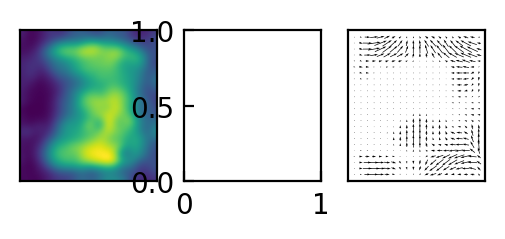

In [101]:
from utils.dataset import JointDataset
dataset = JointDataset([
    ('m_ij', sqh_dataset),
    ('v', sqh_vel_dataset),
    ('c', cad_dataset),
    ('v', cad_vel_dataset)
], 
ensemble=0)

batch = dataset[90]
for key in batch:
    try:
        print(key, batch[key].shape)
    except:
        print(key, batch[key])

from utils.plot_utils import *
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(3, 1))
color_2D(ax[0], batch['c'], cmap='viridis')
#plot_tensor2D(ax[1], batch['m_ij'], cmap='inferno')
plot_vector2D(ax[2], batch['v'])

for a in ax:
    a.set_aspect('auto')

In [108]:
from utils.dataset import TrajectoryDataset
dataset = TrajectoryDataset([
    ('m_ij', sqh_dataset),
    ('v', sqh_vel_dataset),
    ('c', cad_dataset),
    ('v', cad_vel_dataset)
], 
ensemble=0)

print(len(dataset))

batch = dataset[90]
for key in batch:
    try:
        print(key, type(batch[key]))
    except:
        print(key, batch[key], type(batch[key]))
        
loader = torch.utils.data.DataLoader(dataset, batch_size=2, num_workers=0, collate_fn=dataset.collate_fn)
batch = next(iter(loader))
for key in batch:
    try:
        print(key, batch[key].shape)
    except:
        print(key, batch[key])

866
embryoID <class 'torch.Tensor'>
time <class 'torch.Tensor'>
c <class 'torch.Tensor'>
v <class 'torch.Tensor'>
embryoID torch.Size([2, 8])
lengths [8, 7]
time torch.Size([2, 8])
c torch.Size([2, 8, 1, 236, 200])
v torch.Size([2, 8, 2, 236, 200])


In [323]:
from torch.utils.data import Dataset, ConcatDataset

class TrajectoryDataset(Dataset):
    def __init__(self,
                 datasets,
                 dorsal_path='Public/dorsal_mask_ELLIPSE_A=0.5_B=0.25_advected_RESIZED.npy',
                 dorsal_time='Public/dorsal_mask_time.npy',
                 dorsal_sigma=10):
        super(TrajectoryDataset, self).__init__()
        self.datasets = datasets
        
        df = pd.DataFrame(columns=['embryoID', 'time', 'eIdx', 'key'])
        for key in self.datasets:
            dataset = self.datasets[key]

            dfi = dataset.df
            dfi = dfi.drop(['folder', 'tiff'], axis=1)
            dfi['time'] = dfi['time'].astype(int)
            dfi['key'] = [[key] for _ in range(len(dfi))]
            
            df = df.merge(dfi, on=['embryoID', 'time', 'eIdx'], how='outer')
            df.loc[df.key_x.isnull(), 'key_x'] = df.loc[df.key_x.isnull(), 'key_x'].apply(lambda x: [])
            df.loc[df.key_y.isnull(), 'key_y'] = df.loc[df.key_y.isnull(), 'key_y'].apply(lambda x: [])
            df['key'] = df.key_x + df.key_y
            df = df.drop(['key_x', 'key_y'], axis=1)
        
        self.df = pd.DataFrame()
        for eId in df.embryoID.unique():
            sub = df[df.embryoID == eId]
            sub['max_len'] = np.max(sub.time) - sub.time
            self.df = self.df.append(sub[sub.max_len > 1], ignore_index=True)
        
        self.dorsal_source = interp1d(
            np.load(dorsal_time, mmap_mode='r'),
            gaussian_filter(np.load(dorsal_path, mmap_mode='r'), sigma=(0, dorsal_sigma, dorsal_sigma))[:, None],
            axis=0,
            fill_value='extrapolate',
        )
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        embryoID = row.embryoID
        
        seq_len = min(int(np.rint(np.abs(np.random.normal(scale=7)))), row.max_len)
        seq_len = max(seq_len, 2)
        times = np.linspace(row.time, row.time + seq_len, 5).astype(int)
        times = np.unique(times)
        eIdxs = times.copy() - np.min(times) + row.eIdx
        
        sample = {
            'times': torch.from_numpy(times).float(),
        }
        
        for key in self.datasets:
            transform = self.datasets[key].transform
            if key == 'v': #Include all flow data
                data = [transform(self.datasets[key].values[embryoID][eIdx]) for eIdx in range(eIdxs[0], eIdxs[-1]+1)]
            elif key in row.key: #Live-imaged data
                data = [transform(self.datasets[key].values[embryoID][eIdx]) for eIdx in eIdxs]
            else: #Ensemble-averaged data
                df = self.datasets[key].df
                data = []
                for time in times:
                    nearest = df[(df.time - time).abs() < 0.5]
                    if len(nearest) == 0:
                        nearest = df.iloc[(df.time - time).abs().argsort()[:3]]
                    frame = np.mean([transform(self.datasets[key].values[n.embryoID][n.eIdx]) for _, n in nearest.iterrows()], axis=0)
                    data.append(frame)
            sample[key] = torch.from_numpy(np.stack(data)).float()
        
        times = np.arange(times[0], times[-1]+1)
        sample['gamma_ds'] = torch.from_numpy(self.dorsal_source(times))
        
        return sample
                
from utils.dataset import *
from torchvision.transforms import Compose
from atlas_processing.anisotropy_detection import cell_size
transform = Reshape2DField()   
dataset = TrajectoryDataset({
    'm': sqh_dataset,
    'c': cad_dataset,
    'v': vel_dataset,
})
dataset[5]
loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=4)

In [336]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint_adjoint as odeint
from scipy.interpolate import interp1d

def gaussian_kernel1d(sigma, order, radius):
    """
    Computes a 1-D Gaussian convolution kernel.
    """
    if order < 0:
        raise ValueError('order must be non-negative')
    exponent_range = np.arange(order + 1)
    sigma2 = sigma * sigma
    x = np.arange(-radius, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    if order == 0:
        return phi_x
    else:
        # f(x) = q(x) * phi(x) = q(x) * exp(p(x))
        # f'(x) = (q'(x) + q(x) * p'(x)) * phi(x)
        # p'(x) = -1 / sigma ** 2
        # Implement q'(x) + q(x) * p'(x) as a matrix operator and apply to the
        # coefficients of q(x)
        q = np.zeros(order + 1)
        q[0] = 1
        D = np.diag(exponent_range[1:], 1)  # D @ q(x) = q'(x)
        P = np.diag(np.ones(order)/-sigma2, -1)  # P @ q(x) = q(x) * p'(x)
        Q_deriv = D + P
        for _ in range(order):
            q = Q_deriv.dot(q)
        q = (x[:, None] ** exponent_range).dot(q)
        return q * phi_x


class ClosedFlyLoop(nn.Module):
    def __init__(self, sigma=5):
        super(ClosedFlyLoop, self).__init__()
        self.dAP = 2.27
        self.dDV = 2.27
        
        self.gamma_dv = nn.Parameter(torch.FloatTensor([[1., 0.], [0., 0.]])[..., None, None], requires_grad=False)
            
        #D_t c = -0.025 c + 0.064 c trE + 0.261 Gamma^D
        self.cad_coefs = nn.Parameter(torch.FloatTensor([
            0.025, 0.064, 0.261]), requires_grad=True)
        #D_t m = -0.2 m + (1 - 0.4 c) {m, E} + Tr(m) (0.19 Gamma^{DV} + 0.1 m)
        self.myo_coefs = nn.Parameter(torch.FloatTensor([
            0.2, 1., 0.4, 0.19, 0.1]), requires_grad=True)
        
        diff_kernel = gaussian_kernel1d(sigma, 1, radius=int(4*sigma+0.5))[None, None]
        self.diff_kernel = nn.Parameter(torch.FloatTensor(diff_kernel), requires_grad=False)
        self.pad_size = self.diff_kernel.shape[-1] // 2
            
    def diffY(self, x):
        c, h, w = x.shape
        x = x.permute(0, 2, 1)
        x = F.pad(x, (self.pad_size, self.pad_size), mode='circular')
        x = x.view([c*w, 1, h+2*self.pad_size])
        x = F.conv1d(x, self.diff_kernel) / self.dDV
        x = x.view([c, w, h]).permute(0, 2, 1)
        return x
    
    def diffX(self, x):
        c, h, w = x.shape
        x = F.pad(x, (self.pad_size, self.pad_size), mode='reflect')
        x = x.view([c*h, 1, w+2*self.pad_size])
        x = F.conv1d(x, self.diff_kernel) / self.dAP
        x = x.view([c, h, w])
        return x
    
    def forward(self, t, y):
            m = y[:4]
            c = y[4:]

            d1_m = torch.stack([
                self.diffY(m),
                self.diffX(m),
            ], axis=-1).reshape([2, 2, *y.shape[-2:], 2])
            m = m.reshape([2, 2, *y.shape[-2:]])
            
            d1_c = torch.stack([
                self.diffY(c),
                self.diffX(c),
            ], axis=-1).reshape([*y.shape[-2:], 2])
            c = c[0]

            gamma_ds = torch.FloatTensor(self.ds_int(t.item())).to(m.device)
            v = torch.FloatTensor(self.v_int(t.item())).to(m.device)
            d1_v = torch.stack([
                self.diffY(v),
                self.diffX(v)
            ], axis=-1)

            O = -0.5 * (torch.einsum('iyxj->ijyx', d1_v) - \
                        torch.einsum('jyxi->ijyx', d1_v))
            E = 0.5 * (torch.einsum('iyxj->ijyx', d1_v) + \
                       torch.einsum('jyxi->ijyx', d1_v))

            deviatoric = m - 0.5 * torch.einsum('kkyx,ij->ijyx', m, torch.eye(2, device=m.device))

            m_0 = torch.linalg.norm(m, dim=(0, 1), keepdims=True).mean(dim=(2, 3), keepdims=True)
            dev_mag = torch.linalg.norm(deviatoric, dim=(0, 1), keepdims=True)

            devE = torch.einsum('klyx,klyx->yx', deviatoric, E)[None, None]

            E_active = E - torch.sign(devE) * devE * deviatoric / dev_mag**2
            E_active = 0.5 * E_active * dev_mag / m_0 
            E_passive = E - E_active

            mE = torch.einsum('ikyx,kjyx->ijyx', m, E_passive) + \
                 torch.einsum('ikyx,kjyx->ijyx', E_passive, m) 

            cdot =  -1.000 * torch.einsum('iyx,yxi->yx', v, d1_c)
            cdot += -F.relu(self.cad_coefs[0]) * c
            cdot +=  F.relu(self.cad_coefs[1]) * torch.einsum('yx,iyxi->yx', c, d1_v)
            cdot +=  F.relu(self.cad_coefs[2]) * gamma_ds

            trm = torch.einsum('kkyx->yx', m)[None, None]

            mdot =  -1.000 * torch.einsum('kyx,ijyxk->ijyx', v, d1_m)
            mdot -= +1.000 * torch.einsum('ikyx,kjyx->ijyx', O, m)
            mdot -= -1.000 * torch.einsum('ikyx,kjyx->ijyx', m, O)
            mdot += -F.relu(self.myo_coefs[0]) * m
            mdot +=  F.relu(self.myo_coefs[1]) * mE
            mdot += -F.relu(self.myo_coefs[2]) * c[None, None] * mE
            mdot +=  F.relu(self.myo_coefs[3]) * trm * self.gamma_dv
            mdot +=  F.relu(self.myo_coefs[4]) * trm * m

            mdot = mdot.reshape([4, *mdot.shape[-2:]])
            cdot = cdot.reshape([1, *cdot.shape[-2:]])
            ydot = torch.cat([mdot, cdot])
            return ydot
        
def integrate(model, m, c, v, gamma_ds, times):
    '''
    Integrate two fields m, c according to SINDy-identified equations
    Include a co-evolving velocity field and two source fields
    ''' 
    #Set up interpolators for control fields
    times = times.squeeze()
    v = v.squeeze()
    gamma_ds = gamma_ds.squeeze()
    t = np.arange(times[0].item(), times[-1].item()+1)
    v_int = interp1d(t, v.cpu().detach().numpy(), axis=0, fill_value='extrapolate')
    ds_int = interp1d(t, gamma_ds.cpu().detach().numpy(), axis=0, fill_value='extrapolate')
    
    model.v_int = v_int
    model.ds_int = ds_int
    model.t_int = t

    #Set up differentiators
    m = m.reshape([-1, *m.shape[-3:]])
    c = c.reshape([-1, *c.shape[-3:]])
    y0 = torch.cat([m[0], c[0]], dim=0)
    y = odeint(model, y0, times)
    
    m = y[:, :4].reshape([-1, 2, 2, *y.shape[-2:]])
    c = y[:, 4:]
    return m, c, times
    
model = ClosedFlyLoop()
batch = dataset[0]
for key in batch:
    print(key, batch[key].shape)

with torch.no_grad():
    m, c, times = integrate(model, **batch)

times torch.Size([5])
m torch.Size([5, 4, 236, 200])
c torch.Size([5, 1, 236, 200])
v torch.Size([9, 2, 236, 200])
gamma_ds torch.Size([9, 1, 236, 200])


In [342]:
#Train the model
def residual(input, target):
    '''
    Mean-squared error normalized by magnitude of target
    '''
    u = input.reshape([input.shape[0], -1, *input.shape[-2:]])
    v = target.reshape([target.shape[0], -1, *target.shape[-2:]])

    res = torch.pow(u - v, 2).sum(dim=-3)
    mean = torch.linalg.norm(v, axis=-3)
    res /= mean**2

    return res

from torch.utils.data import random_split, DataLoader

def run_train(dataset,
              lr=1e-3,
              logdir='/project/vitelli/jonathan/REDO_fruitfly/tb_logs/',
              grad_clip=0.5,
              epochs=100):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    val_size = len(dataset) // 5
    train, val = random_split(dataset, [len(dataset)-val_size, val_size])
    val_indices = val.indices
    val_df = dataset.df.iloc[val_indices]
    train_loader = DataLoader(train, num_workers=4, batch_size=1, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val, num_workers=4, batch_size=1, shuffle=True, pin_memory=True)

    model = ClosedFlyLoop()
    model.to(device)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

    model_logdir = os.path.join(logdir, model.__class__.__name__)
    if not os.path.exists(model_logdir):
        os.mkdir(model_logdir)

    best_res = 1e5

    for epoch in range(epochs):
        with tqdm(train_loader, unit='batch') as ttrain:
            for batch in ttrain:
                for key in batch:
                    batch[key] = batch[key].to(device)
                m, c, times = integrate(model, **batch)

                optimizer.zero_grad()
                res_m = residual(batch['m'][0], m).mean()
                res_c = residual(batch['c'][0], c).mean()
                loss = res_m + res_c
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                print(res_m.item(), res_c.item(), flush=True)
                break

        val_loss = 0.
        res_m_val = 0.
        res_c_val = 0.
        with torch.no_grad():
            with tqdm(val_loader, unit='batch') as tval:
                for batch in tval:
                    for key in batch:
                        batch[key] = batch[key].to(device)
                    m, c, times = integrate(model, **batch)

                    res_m = residual(batch['m'][0], m).mean()
                    res_c = residual(batch['c'][0], c).mean()
                    loss = res_m + res_c
                    val_loss += loss.item() / len(val_loader)
                    res_m_val += res_m.item() / len(val_loader)
                    res_c_val += res_c.item() / len(val_loader)

        scheduler.step(val_loss)

        outstr = 'Epoch %d\tVal Loss=%g' % (epoch, val_loss)
        outstr += '\tRes Myo=%g\tRes Cad=%g' % (res_m_val, res_c_val)
        print(outstr)
        if val_loss < best_res:
            save_dict = {
                'state_dict': model.state_dict(),
                'hparams': model_kwargs,
                'epoch': epoch,
                'loss': val_loss,
                'val_df': val_df,
            }
            torch.save(
                save_dict, 
                os.path.join(model_logdir, 'checkpoint_Res=%g.ckpt' % val_loss))
            best_res = val_loss
            
    return model

model = run_train(dataset, epochs=1)

  0%|          | 0/693 [00:00<?, ?batch/s]

0.004266912583261728 0.012685522437095642


  5%|▌         | 9/173 [00:10<03:08,  1.15s/batch]


KeyboardInterrupt: 

(5, 2, 2, 236, 200) (5, 1, 236, 200) (5,)


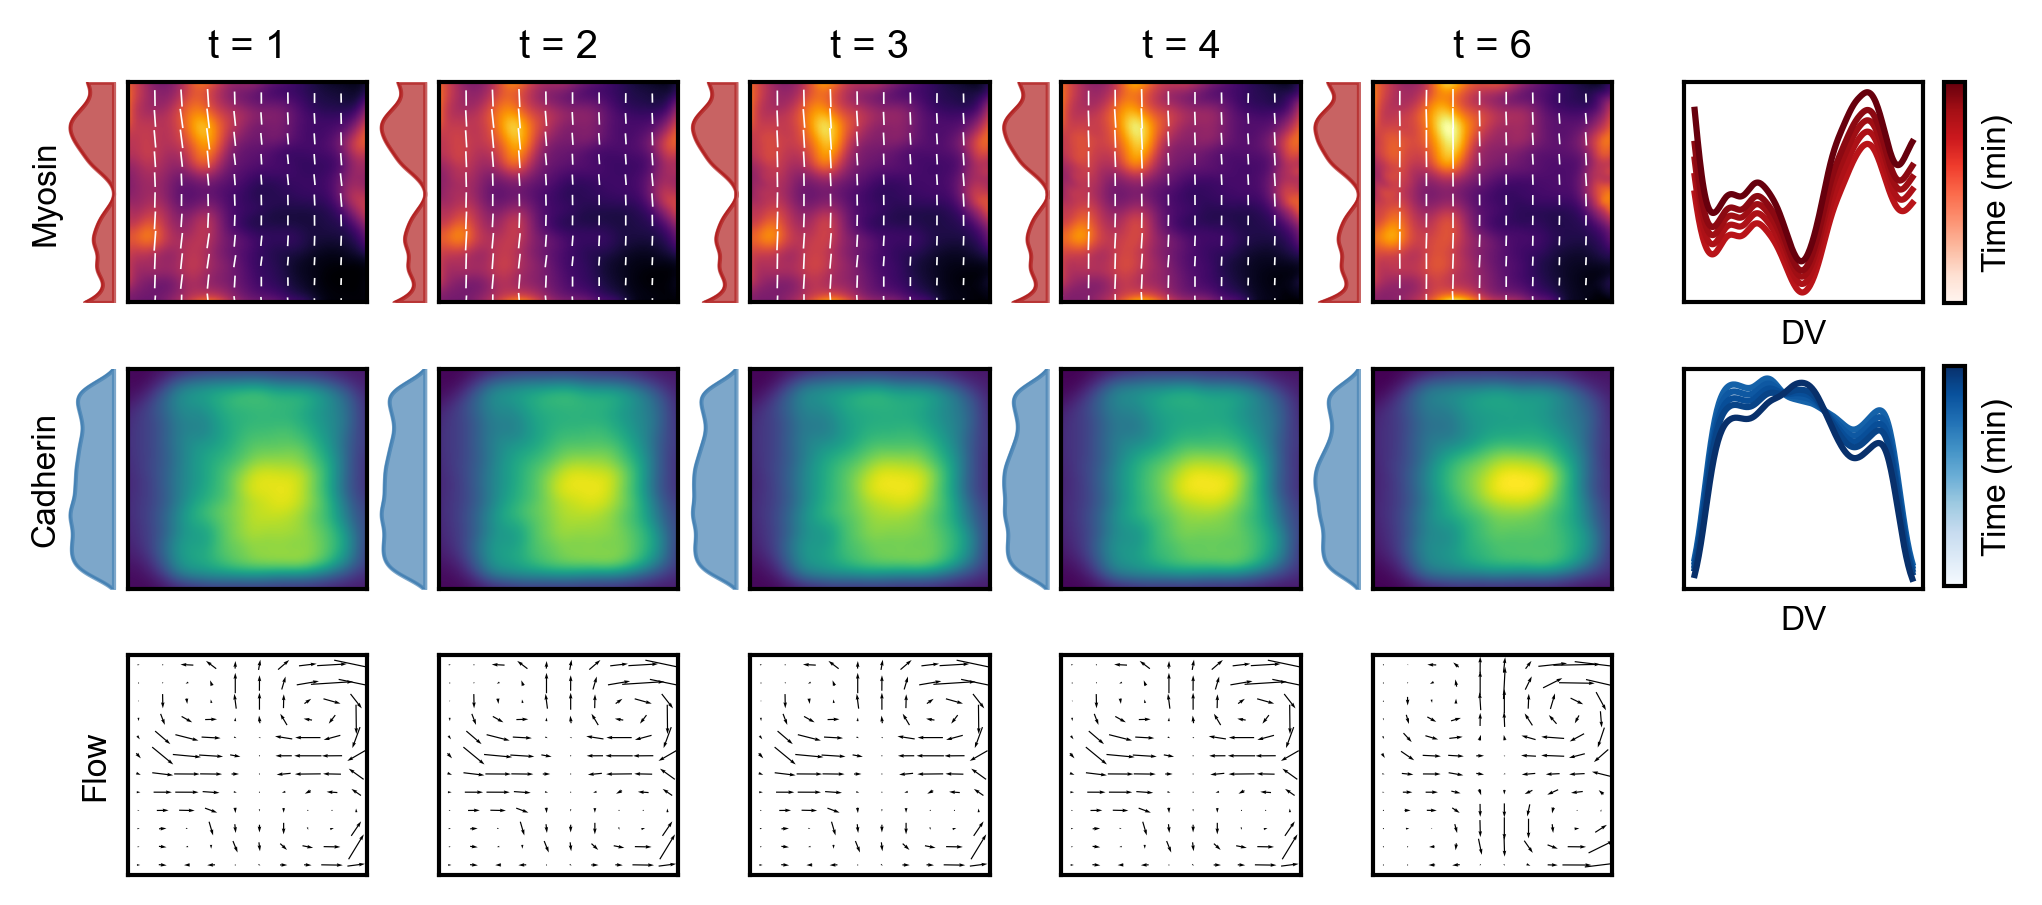

In [300]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'

def plot_with_cuts(ax, ax2, z, time=0, t=None,
                   image_cmap='inferno', 
                   vmin=0, vmax=1,
                   cut_cmap='Greys', 
                   cut_color='tab:red'):
    
    try:
        plot_tensor2D(ax, z, cmap=image_cmap, vmin=vmin, vmax=vmax)
    except:
        color_2D(ax, z, cmap=image_cmap, vmin=vmin, vmax=vmax)
    
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
        
    N0, N1 = 20, 80
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    cut_Y = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
    y = np.linspace(*ax.get_ylim(), len(cut_Y))
    ax_Y.plot(cut_Y, y, color=cut_color, lw=0.5)
    ax_Y.fill_betweenx(y, np.ones_like(cut_Y)*np.min(cut_Y), cut_Y, 
                       color=cut_color, alpha=0.7)
    ax_Y.set(xticks=[], yticks=[])
    ax_Y.invert_xaxis()
    
    ax_Y.axis('off')
    
    color=plt.get_cmap(cut_cmap)((time + 20)/ (np.max(t) + 20))
    ax2.plot(y, 
             cut_Y,
             #(cut_Y - np.min(cut_Y)), 
             color=color)
    
    ax2.set(xticks=[], yticks=[], xlabel='DV')
    
def plot(m, c, v, t):
    print(m.shape, c.shape, t.shape)
    N = 5
    dt = (len(m)-1) // (N-1)

    fig1, ax1 = plt.subplots(3, N+1, figsize=(6+1, 3.5), dpi=300)

    #Boundary crop
    model = pk.load(open('Public/WT/ECad-GFP/decomposition_models/cyt_SVDPipeline.pkl', 'rb'))
    #model = pk.load(open('Public/WT/ECad-GFP/decomposition_models/cyt_SVDPipeline_PMG_CF.pkl', 'rb'))
    ys, xs = np.where(model['masker'].mask_!=0) 
    mask = np.s_[..., min(ys):max(ys)+1, min(xs):max(xs+1)]  

    mnorm = np.linalg.norm(m[mask], axis=(1, 2))[..., :-20]
    mmin = np.min(mnorm)# + 0.5 * np.std(mnorm)
    mmax = np.max(mnorm)#mmin + 7 * np.std(mnorm)#np.max(mnorm)

    cmin = np.min(c[mask])
    cmax = np.max(c[mask])

    def apply_mask(x0, mask, model=model):
        x = x0.copy()
        x[..., ~model['masker'].mask_] = np.nan
        return x[mask]

    for i in range(N):
        ax1[0, i].set_title('t = %d' % (t[dt*i]))

        plot_with_cuts(ax1[0, i], ax1[0, -1], apply_mask(m[dt*i], mask), time=t[dt*i], t=t,
                       cut_color='firebrick', cut_cmap='Reds', image_cmap='inferno',
                       vmin=mmin, vmax=mmax)    
        plot_with_cuts(ax1[1, i], ax1[1, -1], apply_mask(c[dt*i], mask), time=t[dt*i], t=t,
                       cut_color='steelblue', cut_cmap='Blues', image_cmap='viridis',
                       vmin=cmin, vmax=cmax)
        plot_vector2D(ax1[2, i], v[dt*i], skip=20)
        ax1[2, -1].set_visible(False)

    lp=16
    ax1[0, 0].set_ylabel('Myosin', labelpad=lp)
    ax1[1, 0].set_ylabel('Cadherin', labelpad=lp)
    ax1[2, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    fig1.subplots_adjust(right=0.98, wspace=0.3, hspace=0.3)


    cax = fig1.add_axes([0.99, 0.67, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 cax=cax, label='Time (min)', ticks=[])
    cax = fig1.add_axes([0.99, 0.4, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                 cax=cax, label='Time (min)', ticks=[])


    for a in ax1.flatten():
        a.set_aspect('auto')

with torch.no_grad():
    plot(m.numpy(), 
         c.numpy(), 
         v,
         times.numpy())